# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow!



- 🤝 BREAKOUT ROOM #1
  1. Use RAGAS to Generate Synthetic Data

- 🤝 BREAKOUT ROOM #2
  1. Load them into a LangSmith Dataset
  2. Evaluate our RAG chain against the synthetic test data
  3. Make changes to our pipeline
  4. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

# 🤝 BREAKOUT ROOM #1

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

## Dependencies and API Keys:

> NOTE: DO NOT RUN THESE CELLS IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [ ]:
!pip install -qU ragas==0.2.10

In [ ]:
!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 21.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.9/326.9 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.6/306.6 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.1/167.1 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 kB 4.7 MB/s eta 0:00:00
   ━━━━

In [ ]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

LangChain API Key:··········


We'll also want to set a project name to make things easier for ourselves.

In [ ]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [ ]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key:··········


## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [ ]:
!mkdir data

In [ ]:
!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31427    0 31427    0     0   222k      0 --:--:-- --:--:-- --:--:--  224k


In [ ]:
!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70286    0 70286    0     0   112k      0 --:--:-- --:--:-- --:--:--  112k


Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [ ]:
from langchain_community.document_loaders import DirectoryLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()

### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [ ]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [ ]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [ ]:
from ragas.testset.graph import Node, NodeType

for doc in docs:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 2, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [ ]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/26 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 14, relationships: 71)

We can save and load our knowledge graphs as follows.

In [ ]:
kg.save("ai_across_years_kg.json")
ai_across_years_kg = KnowledgeGraph.load("ai_across_years_kg.json")
ai_across_years_kg

KnowledgeGraph(nodes: 14, relationships: 71)

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [ ]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=ai_across_years_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [ ]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

#### ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.


https://github.com/rprav007/aie5_hw7/tree/main

Finally, we can use our `TestSetGenerator` to generate our testset!

In [ ]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,What contributions has Anthropic made to the d...,[Code may be the best application The ethics o...,Anthropic has produced better-than-GPT-3 class...,single_hop_specifc_query_synthesizer
1,Why Chinese grammar harder than code grammar?,[Based Development As a computer scientist and...,The grammar rules of programming languages lik...,single_hop_specifc_query_synthesizer
2,What insights did Simon Willison share about t...,[Simon Willison’s Weblog Subscribe Stuff we fi...,Simon Willison highlighted that 2023 was a bre...,single_hop_specifc_query_synthesizer
3,What are the ethical concerns associated with ...,[easy to follow. The rest of the document incl...,The ethical concerns associated with training ...,single_hop_specifc_query_synthesizer
4,what gemini 1.5 pro do with video and tokens?,[Prompt driven app generation is a commodity a...,Gemini 1.5 Pro introduced the ability to input...,single_hop_specifc_query_synthesizer
5,How has OpenAI contributed to the ethical disc...,[<1-hop>\n\nCode may be the best application T...,OpenAI has played a significant role in the de...,multi_hop_abstract_query_synthesizer
6,What are the ethical concerns related to the t...,[<1-hop>\n\nCode may be the best application T...,The ethical concerns related to the training d...,multi_hop_abstract_query_synthesizer
7,What are the ethical implications of using unl...,[<1-hop>\n\nCode may be the best application T...,The ethical implications of using unlicensed t...,multi_hop_abstract_query_synthesizer
8,How did the advancements in GPT-4 and its succ...,[<1-hop>\n\nfeed with the model and talk about...,"In 2024, the advancements in GPT-4 and its suc...",multi_hop_specific_query_synthesizer
9,How does the environmental impact of training ...,[<1-hop>\n\nthat. DeepSeek v3 is a huge 685B p...,The environmental impact of training large lan...,multi_hop_specific_query_synthesizer


### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [ ]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/26 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What advancements have been made in AI models ...,[Prompt driven app generation is a commodity a...,"Since the release of GPT-4, significant advanc...",single_hop_specifc_query_synthesizer
1,Wut iz the role of Amazon Nova in the context ...,"[gets you OpenAI’s most expensive model, o1. G...",Amazon Nova is mentioned as having pre-announc...,single_hop_specifc_query_synthesizer
2,What feature did Mistral Chat introduce in Nov...,[feed with the model and talk about what you c...,Mistral Chat added a feature called Canvas in ...,single_hop_specifc_query_synthesizer
3,What is the significance of ASML in the contex...,[dependent on AGI itself. A model that’s robus...,"In the context provided, ASML is used metaphor...",single_hop_specifc_query_synthesizer
4,How have advancements in model training costs ...,[<1-hop>\n\nCode may be the best application T...,Advancements in model training costs have sign...,multi_hop_abstract_query_synthesizer
5,How does the black box nature of Large Languag...,[<1-hop>\n\nCode may be the best application T...,The black box nature of Large Language Models ...,multi_hop_abstract_query_synthesizer
6,How has OpenAI influenced the development of A...,[<1-hop>\n\nCode may be the best application T...,OpenAI has played a significant role in the de...,multi_hop_abstract_query_synthesizer
7,How does the black box nature of Large Languag...,[<1-hop>\n\nCode may be the best application T...,The black box nature of Large Language Models ...,multi_hop_abstract_query_synthesizer
8,How has Meta contributed to the advancements i...,[<1-hop>\n\nPrompt driven app generation is a ...,Meta has significantly contributed to advancem...,multi_hop_specific_query_synthesizer
9,How did the advancements in 2024 lead to the c...,[<1-hop>\n\nPrompt driven app generation is a ...,"In 2024, the GPT-4 barrier was comprehensively...",multi_hop_specific_query_synthesizer


We'll need to provide our LangSmith API key, and set tracing to "true".

# 🤝 BREAKOUT ROOM #2

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [ ]:
from langsmith import Client

client = Client()

dataset_name = "State of AI Across the Years - v3"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="State of AI Across the Years v3"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [ ]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [ ]:
rag_documents = docs

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [ ]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [ ]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="State of AI"
)

In [ ]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [ ]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

Finally, we can set-up our RAG LCEL chain!

In [ ]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [ ]:
rag_chain.invoke({"question" : "What are Agents?"})

'"Agents" is a term that lacks a single, clear, and widely understood meaning. It generally refers to AI systems that can act on your behalf, but interpretations vary. Some people view them as similar to travel agents, while others think of them as large language models (LLMs) with access to tools for solving problems. The concept is often associated with autonomy, but there is skepticism about their actual utility, particularly due to challenges like gullibility in AI systems.'

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4o as our evaluation LLM for our base Evaluators.

In [ ]:
eval_llm = ChatOpenAI(model="gpt-4o")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [ ]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

dope_or_nope_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "dopeness": "Is this submission dope, lit, or cool?",
        },
        "llm" : eval_llm
    }
)

#### 🏗️ Activity #2:

Highlight what each evaluator is evaluating.

- `qa_evaluator`:
- `labeled_helpfulness_evaluator`:
- `dope_or_nope_evaluator`:

https://github.com/rprav007/aie5_hw7/tree/main

## LangSmith Evaluation

In [ ]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

View the evaluation results for experiment: 'healthy-trouble-24' at:
https://smith.langchain.com/o/7060d864-7d43-496b-8e62-4e83c9c6e8e7/datasets/5e543221-f446-4067-a5b7-c3403b22e32f/compare?selectedSessions=04171f97-9fcb-43ba-bc34-b3a4c81f7947




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How does the concept of gullibility in languag...,The concept of gullibility in language models ...,None,The concept of gullibility in language models ...,1,1,0,4.594304,7b5ddd20-0711-48b3-be44-78b189ac5501,14c3671b-ed0a-4276-b98c-e3c7c3ed1ff4
1,How has Anthropic contributed to the developme...,I don't know.,None,Anthropic has contributed to the development o...,0,0,0,0.963266,08f9327a-37a8-4d00-abba-aa483c438267,c5f9bb87-e675-43c3-82e9-25dc934b5092
2,What are the cost and efficiency improvements ...,I don't know.,None,GPT-4o is significantly more cost-effective th...,0,0,0,0.677648,f69588d0-6de1-4693-9495-d13a3bc71802,2fe3d662-0b24-4a74-835c-a265816c34cf
3,How has the development of Claude 3 and its su...,I don't know.,None,The development of Claude 3 and its subsequent...,0,0,0,0.875561,a4592573-956d-4995-8092-5181591751ea,31bea987-cac5-4e97-aed7-3c5c55fbfc87
4,What are the challenges and ethical concerns a...,The challenges and ethical concerns associated...,None,Large Language Models (LLMs) are often conside...,1,1,0,11.053575,ac5195f8-39d1-49df-b239-75530c481357,9ffcde61-7e51-40f0-9235-f36d54c986a0
5,What are the ethical challenges associated wit...,The ethical challenges associated with the tra...,None,The ethical challenges associated with the tra...,1,0,0,1.723053,9a2b3082-7dfd-4d30-bf75-5970ad12e6f2,bb921450-41be-4686-8320-8b98c2661818
6,What are the ethical challenges associated wit...,The ethical challenges associated with the tra...,None,The ethical challenges associated with the tra...,1,1,0,2.508472,79acd67c-65f5-46ac-a840-3507e6fab1f6,d82f1cdf-f373-4fd2-87be-8adb653703f5
7,What are the ethical and technical challenges ...,I don't know.,None,The ethical and technical challenges associate...,0,0,0,1.213423,f3e00a91-8378-468f-88c6-f2993c320857,6b329738-0b55-4c5d-b73f-f7cf5381c627
8,What was the impact of the leaked Google docum...,I don't know.,None,The leaked Google document titled 'We Have No ...,0,0,0,0.829424,108dd809-dda8-4612-b5c5-eab541fd6d14,78f60def-dc66-4df6-85fa-611f7d5ac4c1
9,Wht are the key highlights of Large Languge Mo...,The key highlights of Large Language Models (L...,None,"In 2023, Large Language Models (LLMs) were hig...",1,1,1,5.074347,ba5f7935-2c39-40e9-b42e-21d1b55695ee,ecd46983-2ad1-4be8-b78f-da2343dd6712


## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [ ]:
DOPE_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the questions in a dope way, be cool!

Context: {context}
Question: {question}
"""

dope_rag_prompt = ChatPromptTemplate.from_template(DOPE_RAG_PROMPT)

In [ ]:
rag_documents = docs

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

#### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

https://github.com/rprav007/aie5_hw7/tree/main

In [ ]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

https://github.com/rprav007/aie5_hw7/tree/main

In [ ]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="AI Across Years (Augmented)"
)

In [ ]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [ ]:
dope_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dope_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [ ]:
dope_rag_chain.invoke({"question" : "what are Agents?"})

'Yo, Agents are like those mysterious AI systems that are supposed to act on your behalf, but the term is mad vague. Some folks think of them as digital helpers, like travel agents, while others see them as LLMs running tools to solve problems. The catch? There\'s no clear definition, and honestly, they still feel like they\'re always "coming soon." So, it\'s a bit of a wild card situation, you know?'

Finally, we can evaluate the new chain on the same test set!

In [ ]:
evaluate(
    dope_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "dope_chain"},
)

View the evaluation results for experiment: 'definite-cook-84' at:
https://smith.langchain.com/o/7060d864-7d43-496b-8e62-4e83c9c6e8e7/datasets/5e543221-f446-4067-a5b7-c3403b22e32f/compare?selectedSessions=8f1d5fa4-9bc4-475e-a7c8-84c2c19a40b3




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How does the concept of gullibility in languag...,"Yo, the whole vibe around gullibility in langu...",None,The concept of gullibility in language models ...,1,1,1,4.562587,7b5ddd20-0711-48b3-be44-78b189ac5501,c2ee6c4b-2138-4127-a04f-3a8ec483f5f0
1,How has Anthropic contributed to the developme...,"Yo, Anthropic is in the game, rolling out mode...",None,Anthropic has contributed to the development o...,1,1,1,3.474524,08f9327a-37a8-4d00-abba-aa483c438267,0624e611-3071-4716-850f-5c89339bb0f1
2,What are the cost and efficiency improvements ...,"Yo, check it out! GPT-4o is rocking a price of...",None,GPT-4o is significantly more cost-effective th...,1,1,1,3.488527,f69588d0-6de1-4693-9495-d13a3bc71802,6e001a03-57ee-46dc-86cb-07bf40b20f1c
3,How has the development of Claude 3 and its su...,"Yo, Claude 3 and its upgrades have totally shi...",None,The development of Claude 3 and its subsequent...,1,0,1,5.205525,a4592573-956d-4995-8092-5181591751ea,42ef708e-771b-48ce-b436-13ed9f97a406
4,What are the challenges and ethical concerns a...,"Yo, the challenges with LLMs being seen as bla...",None,Large Language Models (LLMs) are often conside...,1,1,1,5.192107,ac5195f8-39d1-49df-b239-75530c481357,2913da27-d586-4e18-8afc-d10ddb553c92
5,What are the ethical challenges associated wit...,"Yo, the ethical challenges around the training...",None,The ethical challenges associated with the tra...,1,1,1,3.025927,9a2b3082-7dfd-4d30-bf75-5970ad12e6f2,918d1bef-4446-4506-ab35-7b95c65617a1
6,What are the ethical challenges associated wit...,"Yo, the ethical challenges lurking around the ...",None,The ethical challenges associated with the tra...,1,1,1,3.633546,79acd67c-65f5-46ac-a840-3507e6fab1f6,aea825ef-9578-4f60-85ed-95e96ddcbb02
7,What are the ethical and technical challenges ...,"Yo, the ethical and technical challenges with ...",None,The ethical and technical challenges associate...,1,0,1,4.594391,f3e00a91-8378-468f-88c6-f2993c320857,520ac003-cde7-4687-97ed-8ac105339095
8,What was the impact of the leaked Google docum...,I don't know.,None,The leaked Google document titled 'We Have No ...,0,1,0,3.605421,108dd809-dda8-4612-b5c5-eab541fd6d14,4aa3f785-6e37-4ff0-8c74-544456fa3db2
9,Wht are the key highlights of Large Languge Mo...,"Yo, here are the key highlights of Large Langu...",None,"In 2023, Large Language Models (LLMs) were hig...",1,1,1,3.213827,ba5f7935-2c39-40e9-b42e-21d1b55695ee,acde0b43-3676-4bb7-859b-8227018ce2ab


#### 🏗️ Activity #3:

Provide a screenshot of the difference between the two chains, and explain why you believe certain metrics changed in certain ways.


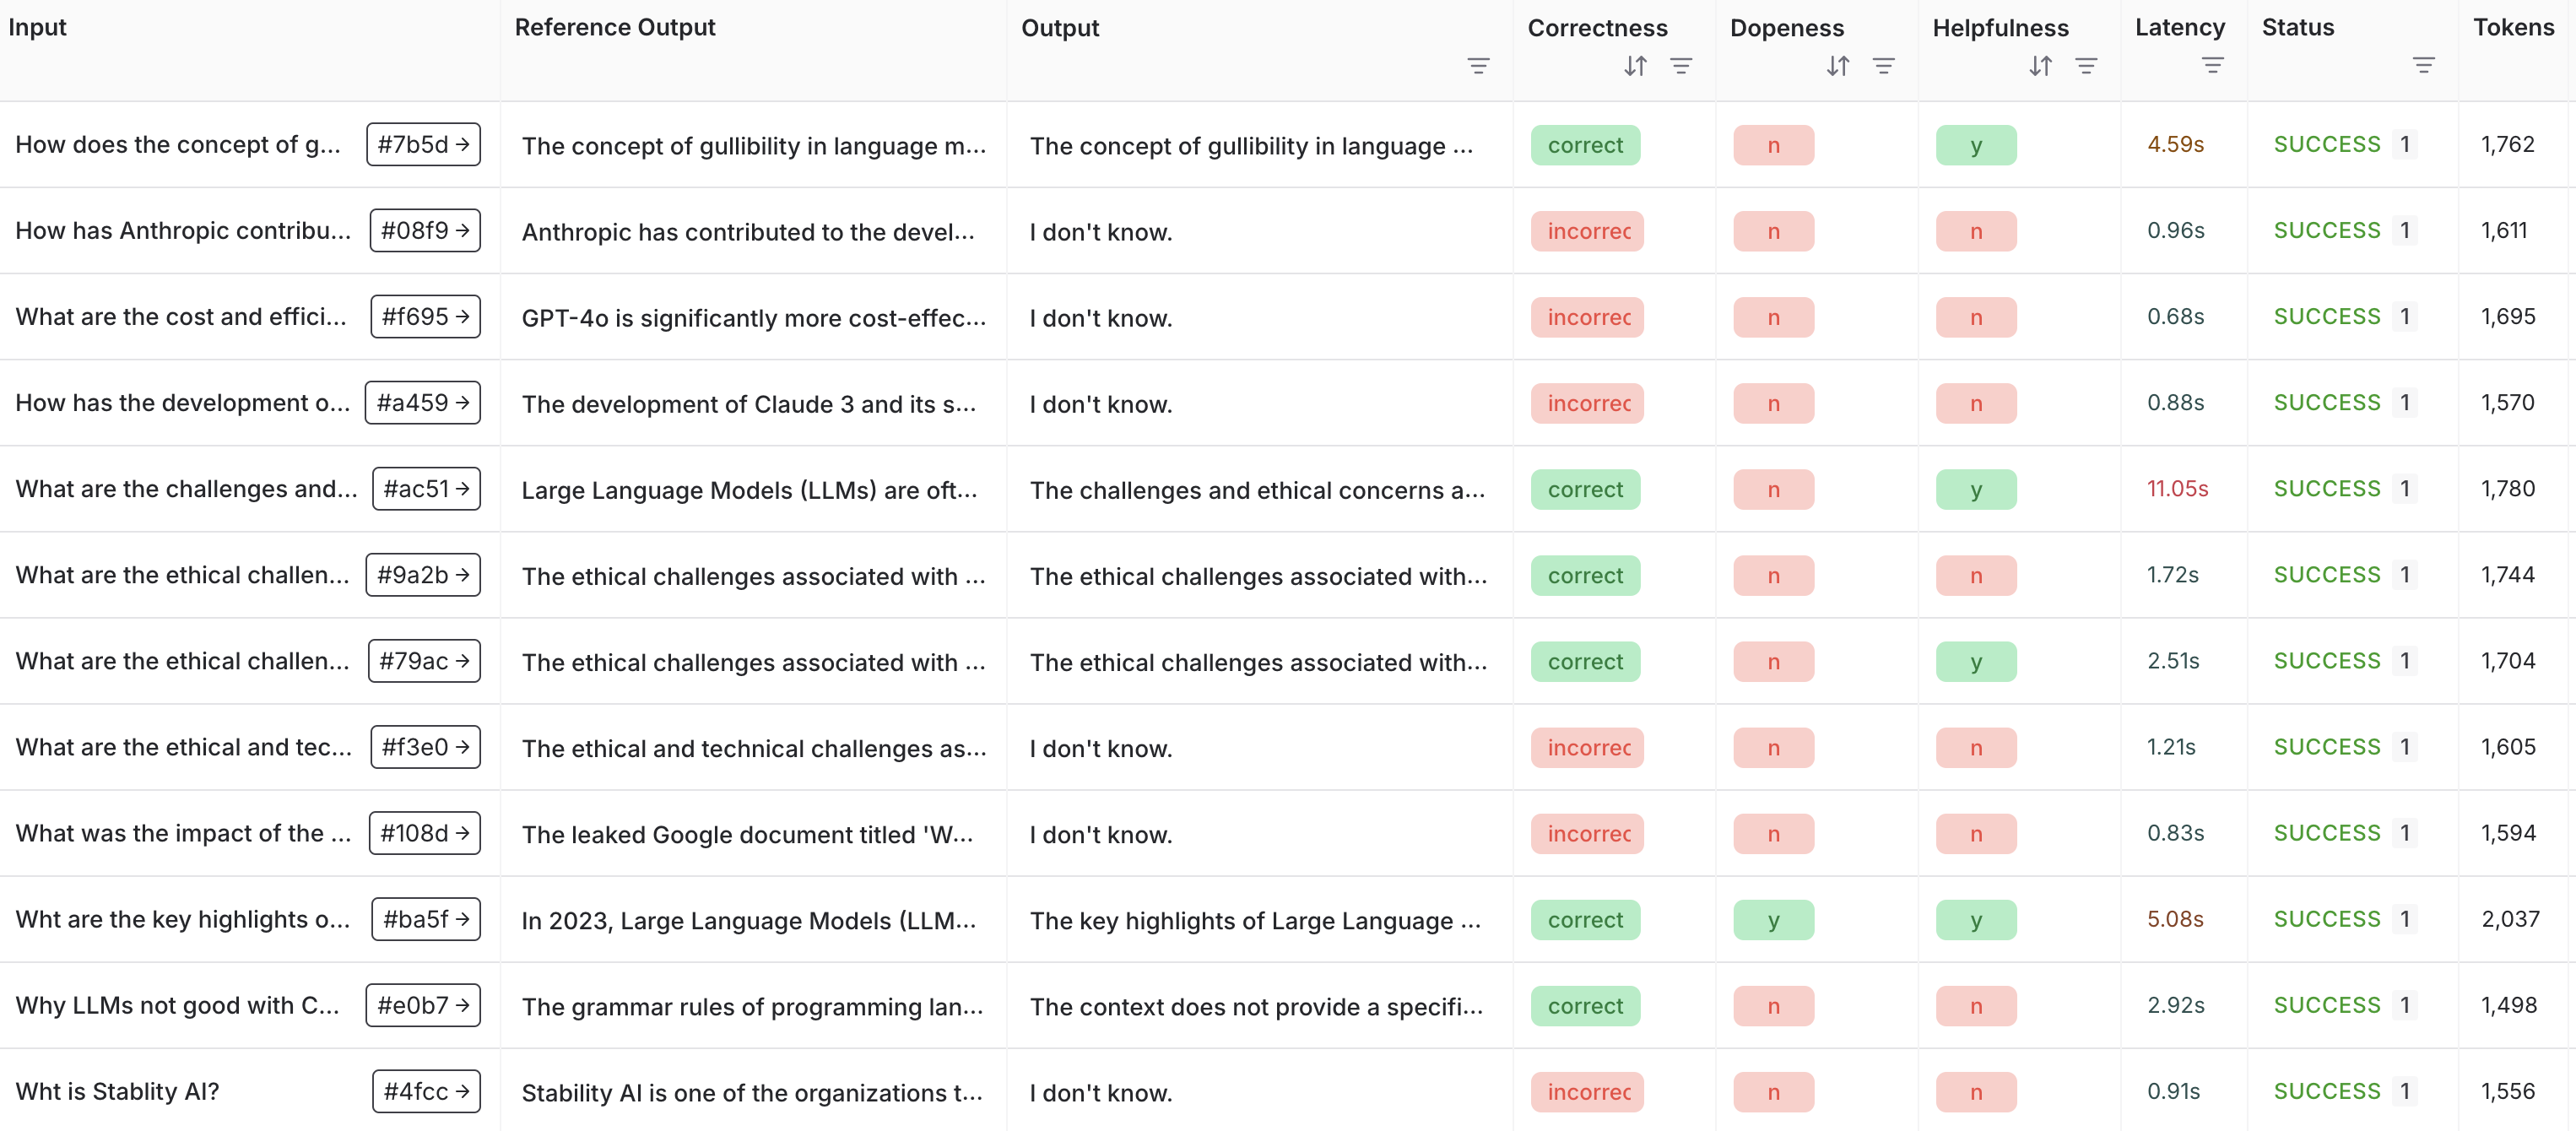

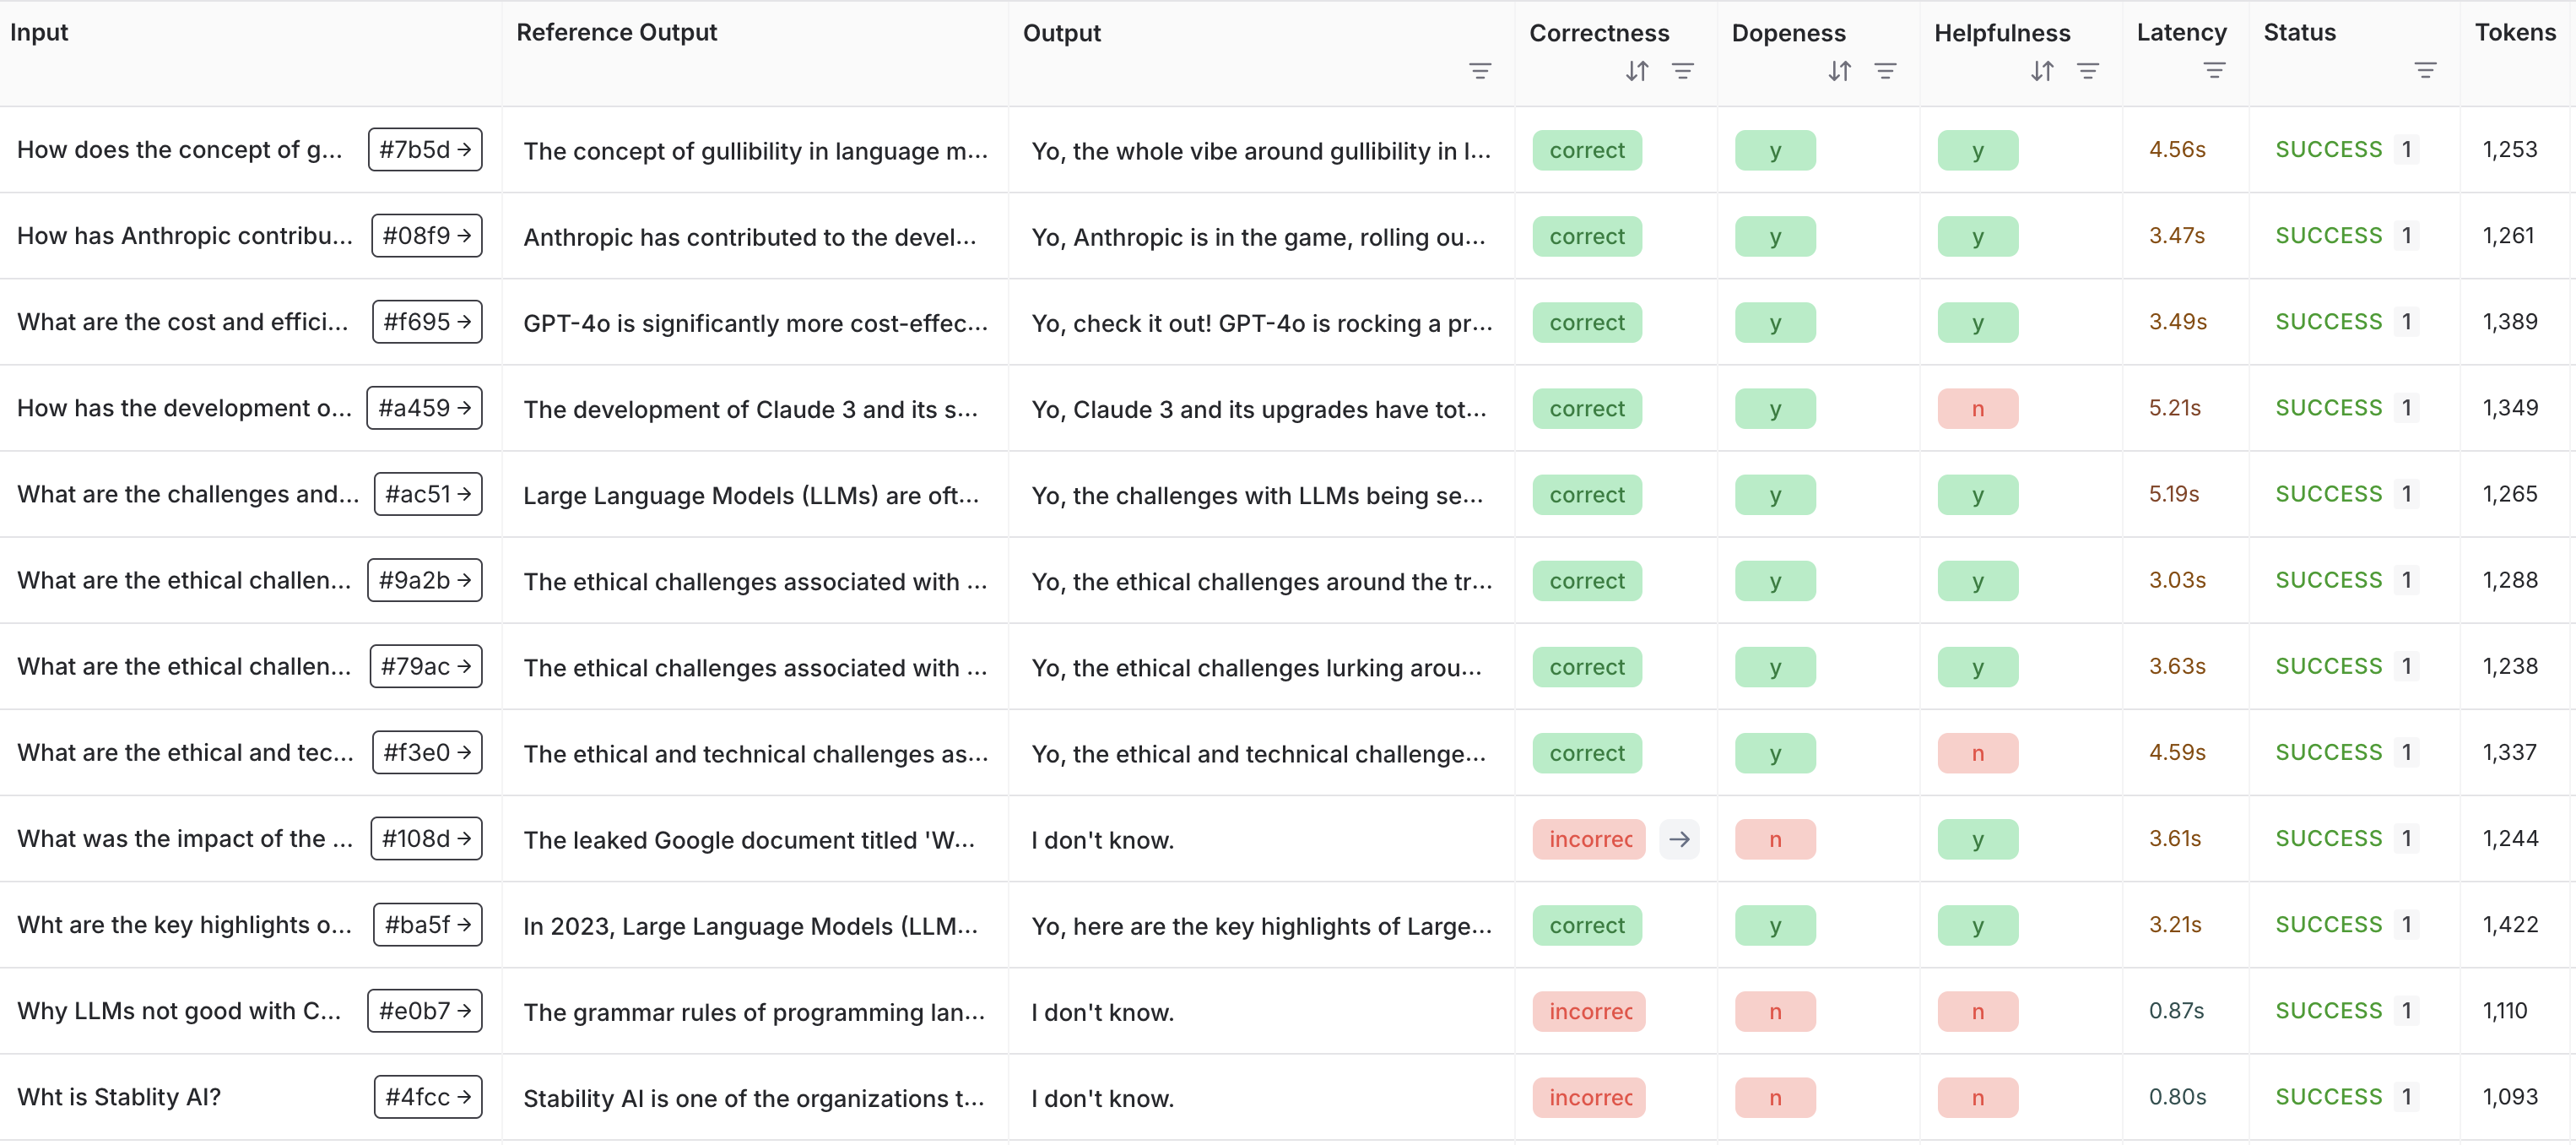

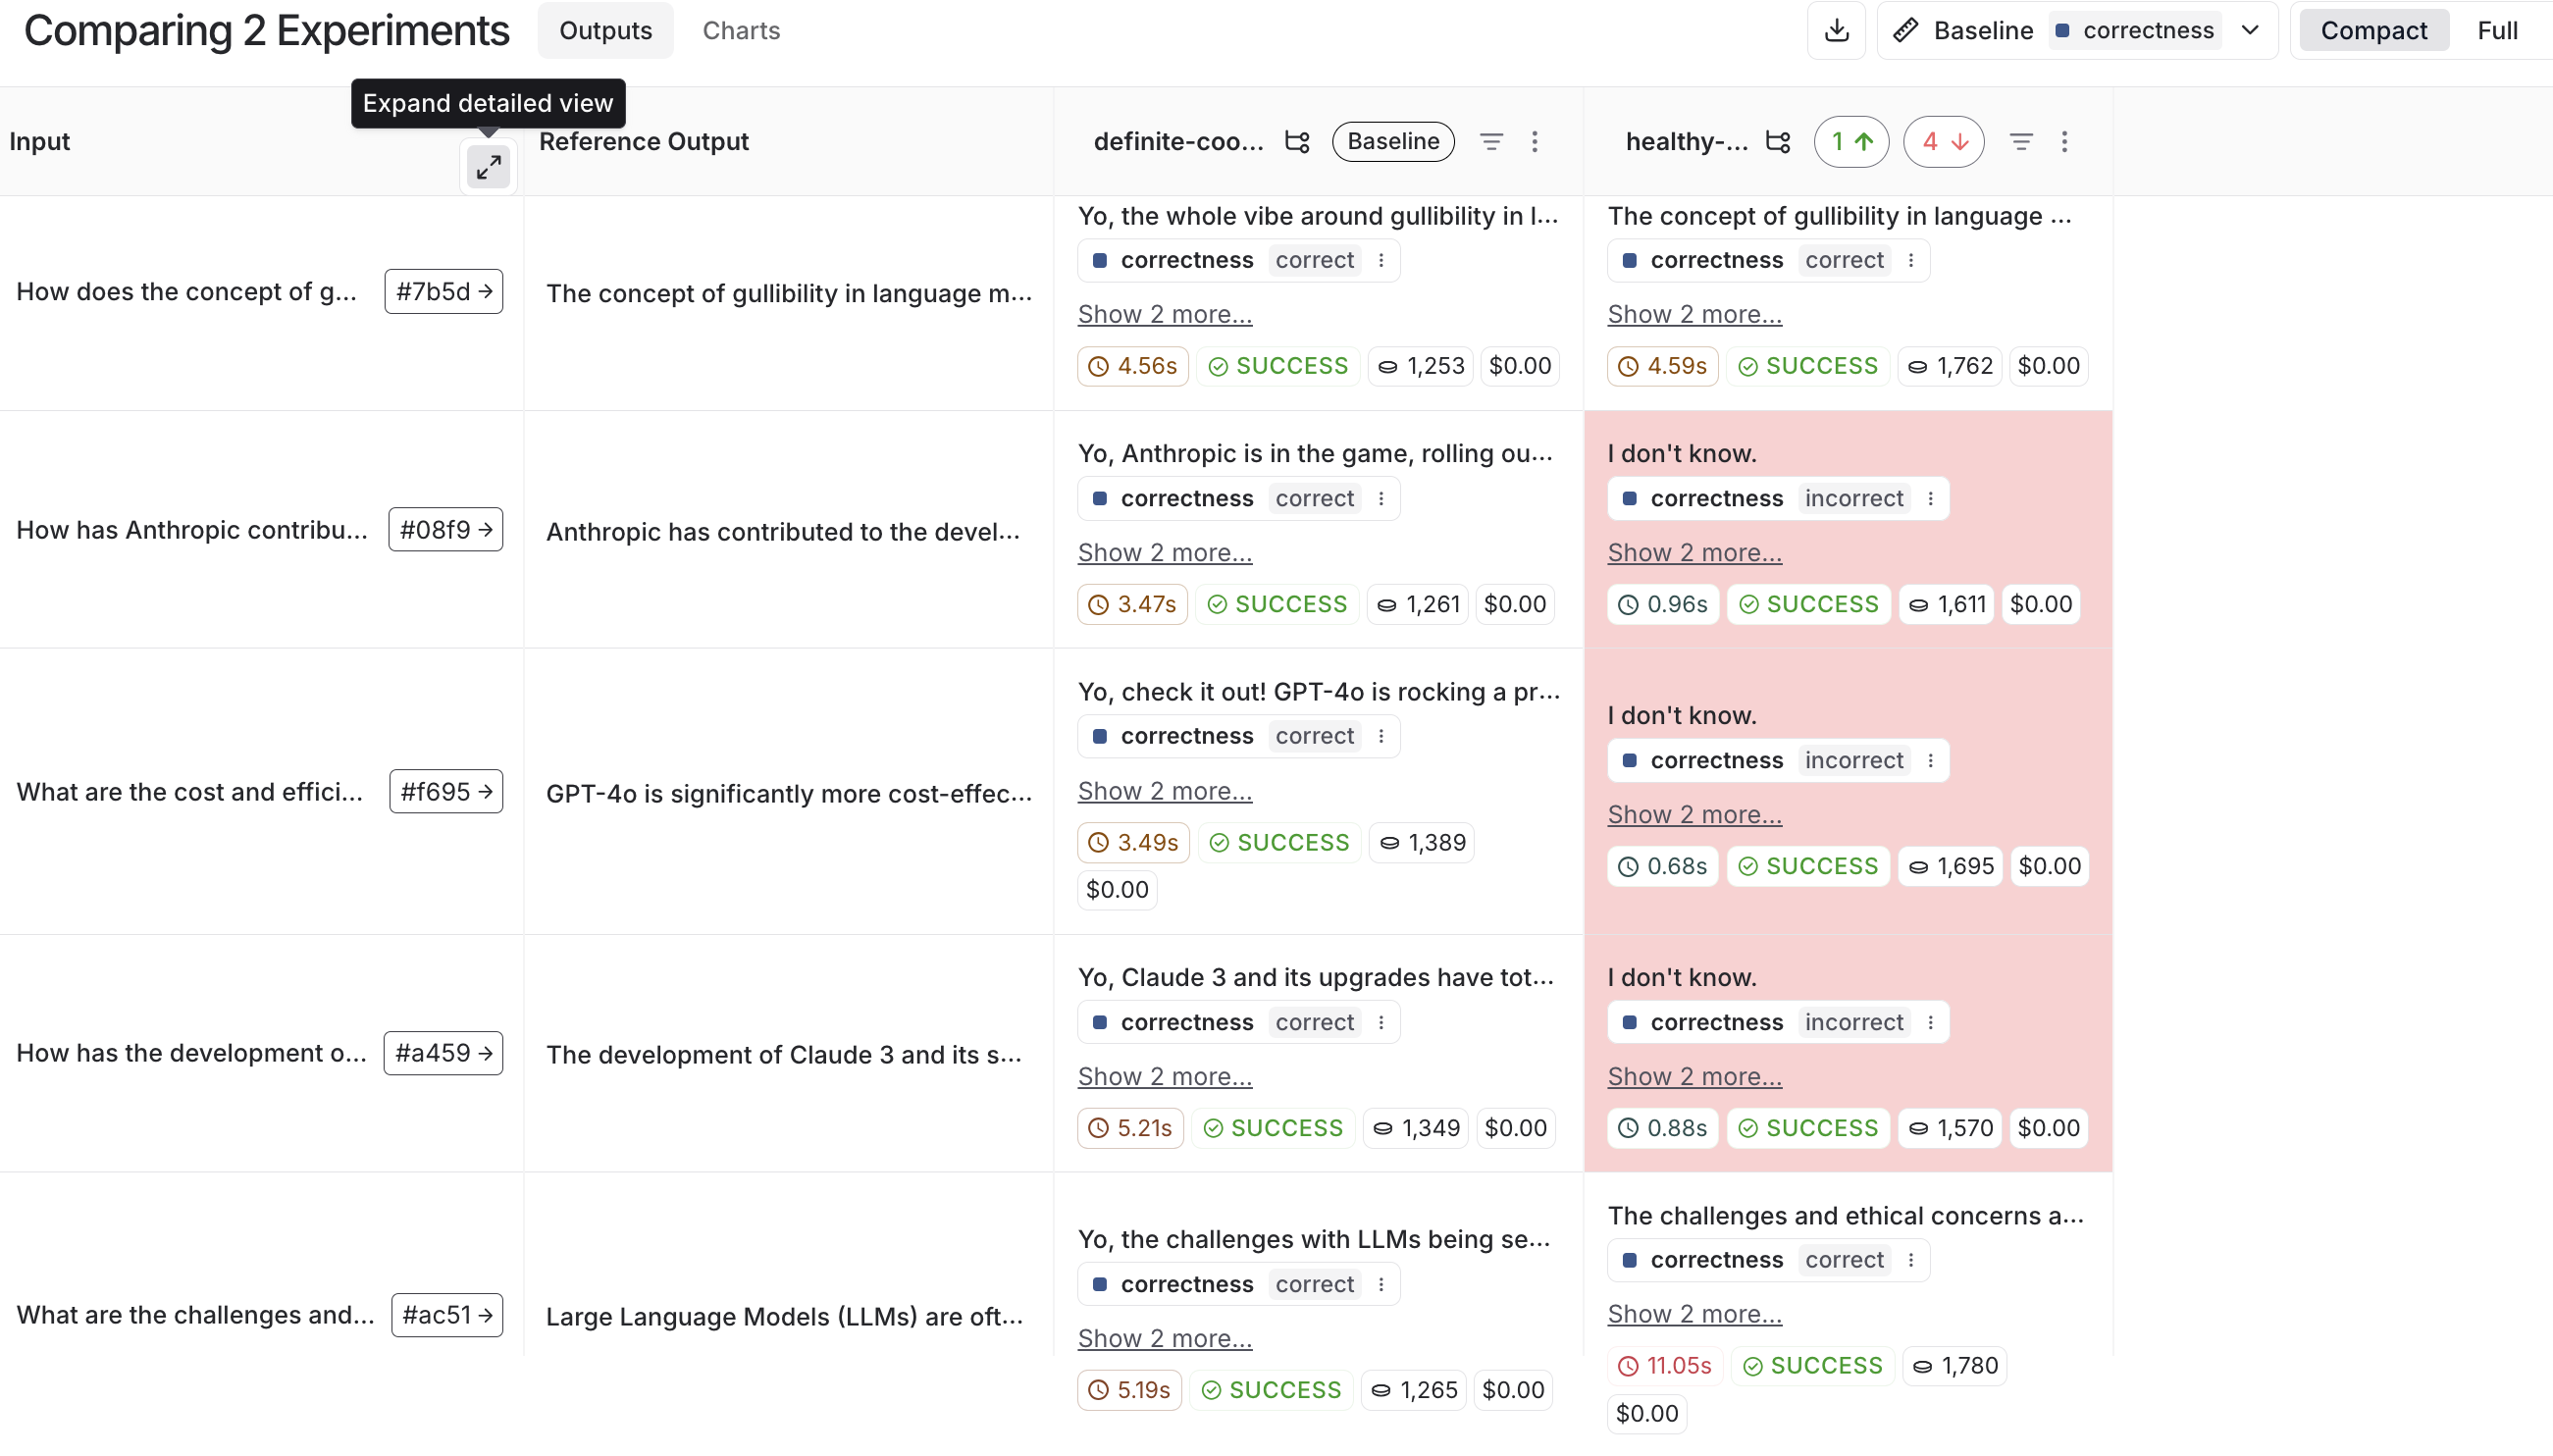

https://github.com/rprav007/aie5_hw7/tree/main